## Functions definitions

In [1]:
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from tqdm import trange
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel, TimeSeriesTransformerForPrediction
from fastdtw import fastdtw
from sklearn.manifold import TSNE

In [2]:
%load_ext autoreload
%autoreload 2

from tscnn_classifier import TimeSeriesCNN
from plot_functions import plot_metrics, plot_aug, plot, plot_results
from train import train

In [3]:
batch_size = 32
criterion = nn.BCELoss()
num_epochs = 6
n_experiments = 3
augments_per_sample = 1

In [4]:
def load_data(dataset, old=False):
    if old:
        if dataset == "ihb":
            close = np.load("close_mean_ts_by_network.npy")
            open = np.load("open_mean_ts_by_network.npy")
        elif dataset == "china":
            open = np.load("china_open_mean_ts_by_network_HCPex.npy")
            close = np.load("china_close_mean_ts_by_network_HCPex.npy")
        elif dataset == "china_cut":
            open = np.load("china_open_mean_ts_by_network_HCPex.npy")
            close = np.load("china_close_mean_ts_by_network_HCPex.npy")
            close = close[:, :48, :]
        else:
            print("dataset must be ihb, china or china_cut.")
            return

        data = np.concatenate((close, open), axis=1)
        data = torch.tensor(data).float()
        data = data.reshape((data.shape[1], data.shape[0], data.shape[2]))
        return close, open, data
    else:
        if dataset == "ihb":
            close = np.load("ihb_close_mean_HCPex.npy")
            open = np.load("ihb_open_mean_HCPex.npy")
        elif dataset == "china":
            open = np.load("china_open_mean_HCPex.npy")
            close = np.load("china_close_mean_HCPex.npy")
        elif dataset == "china_cut":
            open = np.load("china_open_mean_HCPex.npy")
            close = np.load("china_close_mean_HCPex.npy")
            close = close[:48]
        else:
            print("dataset must be ihb, china or china_cut.")
            return
        data = np.concatenate((close, open), axis=0)
        data = torch.tensor(data).float()
        data = data.reshape((data.shape[0], data.shape[2], data.shape[1]))
        close = close.reshape((close.shape[2], close.shape[0], close.shape[1]))
        open = open.reshape((open.shape[2], open.shape[0], open.shape[1]))
        return close, open, data


In [5]:
def conduct_experiments(data, labels, conv_output_size=1120, num_epochs=num_epochs):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)
    metrics = []

    for _ in range(n_experiments):
        for _, (train_index, test_index) in enumerate(kf.split(data, labels)):

            train_data = data[train_index]
            train_labels = labels[train_index]
            test_data = data[test_index]
            test_labels = labels[test_index]

            train_dataset = TensorDataset(train_data, train_labels)
            test_dataset = TensorDataset(test_data, test_labels)
            train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=33)

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

            model = TimeSeriesCNN(data.shape[1], conv_output_size=conv_output_size)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=0.02)
            experiment_metrics = train(model, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs)
            metrics.append(experiment_metrics)

    metrics = np.array(metrics)
    return plot_metrics(metrics[:,0,:], metrics[:,1,:], metrics[:,2,:], metrics[:,3,:], metrics[:,4,:], num_epochs)

In [6]:
def conduct_experiments_aug(data, augmented_data, labels, aug_labels, conv_output_size=1120, num_epochs=num_epochs):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)
    metrics = []

    for _ in range(n_experiments):
        for _, (train_index_orig, test_index_orig) in enumerate(kf.split(data, labels)):
            train_index = []
            for x in train_index_orig:
                for i in range(augmented_data.shape[0] // data.shape[0]):
                    train_index.append(augments_per_sample * x + i)
            train_data = augmented_data[train_index]
            train_labels = aug_labels[train_index]
            test_data = data[test_index_orig]
            test_labels = labels[test_index_orig]

            train_dataset = TensorDataset(train_data, train_labels)
            test_dataset = TensorDataset(test_data, test_labels)
            train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=33)

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

            model = TimeSeriesCNN(data.shape[1], conv_output_size=conv_output_size)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=0.02)
            experiment_metrics = train(model, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs)
            metrics.append(experiment_metrics)

    metrics = np.array(metrics)
    return plot_metrics(metrics[:,0,:], metrics[:,1,:], metrics[:,2,:], metrics[:,3,:], metrics[:,4,:], num_epochs)

In [7]:
def add_noise(data, noise_level=0.1):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def scale(data, scale_factor=0.1):
    factor = np.random.uniform(1 - scale_factor, 1 + scale_factor)
    return data * factor

def shift(data, shift_max=2):
    shift = np.random.randint(-shift_max, shift_max)
    shifted_data = np.roll(data, shift, axis=1)
    return shifted_data

def augment_data(data, labels, augmentations_per_sample=augments_per_sample):
    augmented_data = []
    augmented_labels = []
    for i in range(data.shape[0]):
        for _ in range(augmentations_per_sample):
            augmented_sample = data[i]
            augmented_sample = add_noise(augmented_sample)
            if random.choice([True, False]):
                augmented_sample = scale(augmented_sample)
            if random.choice([True, False]):
                augmented_sample = shift(augmented_sample)
            augmented_data.append(augmented_sample)
            augmented_labels.append(labels[i])
    return np.array(augmented_data), np.array(augmented_labels)

In [8]:
class DiffusionModel(nn.Module):
    def __init__(self, input_shape):
        super(DiffusionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def augment_data_with_diffusion(data, model, num_augments=augments_per_sample):
    model.eval()
    augmented_data = []
    with torch.no_grad():
        for sample in data:
            sample = torch.tensor(sample, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            for _ in range(num_augments):
                noise = torch.randn_like(sample) * 0.1
                noisy_sample = sample + noise
                augmented_sample = model(noisy_sample)
                augmented_data.append(augmented_sample.squeeze().numpy())
    return np.array(augmented_data)

def train_diffusion(data):
    input_shape = (1, 14, 120)
    model = DiffusionModel(input_shape)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in trange(10):
        model.train()
        for sample in data:
            sample = torch.tensor(sample, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            optimizer.zero_grad()
            output = model(sample)
            loss = criterion(output, sample)
            loss.backward()
            optimizer.step()
    return model

In [9]:
def get_aug_data(data, aug_type, dataset_name):
    if aug_type == "baseline":
        augmented_data, aug_labels = augment_data(data, labels)
        augmented_data = torch.Tensor(augmented_data)
    elif aug_type == "diffusion":
        model = train_diffusion(data)
        augmented_data = augment_data_with_diffusion(data, model)
        augmented_data = torch.Tensor(augmented_data)
        aug_labels = [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample)
    elif aug_type == "transformer":
        augmented_data = torch.load("fmri/aug_data_" + dataset_name + ".pt")
        aug_labels = [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample)
    else:
        print("aug_type must be baseline, diffusion or transformer")
        return
    aug_labels = torch.tensor(aug_labels).float()
    return augmented_data, aug_labels

## IHB dataset

In [10]:
dataset_name = "ihb"
close, open, data = load_data(dataset_name)
labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

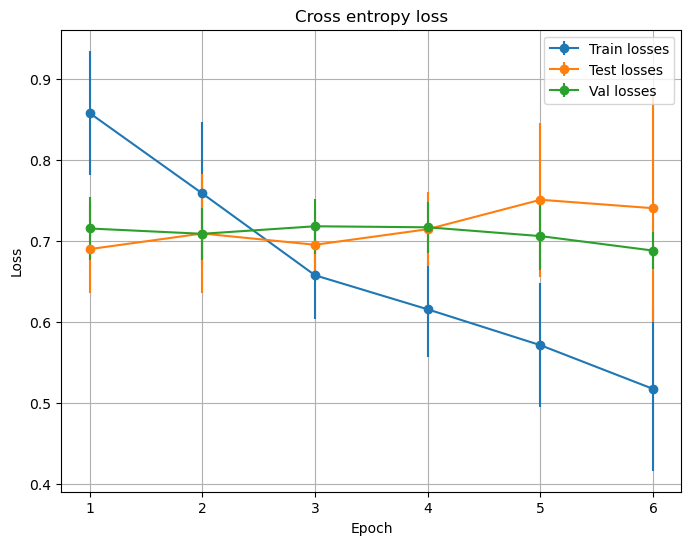

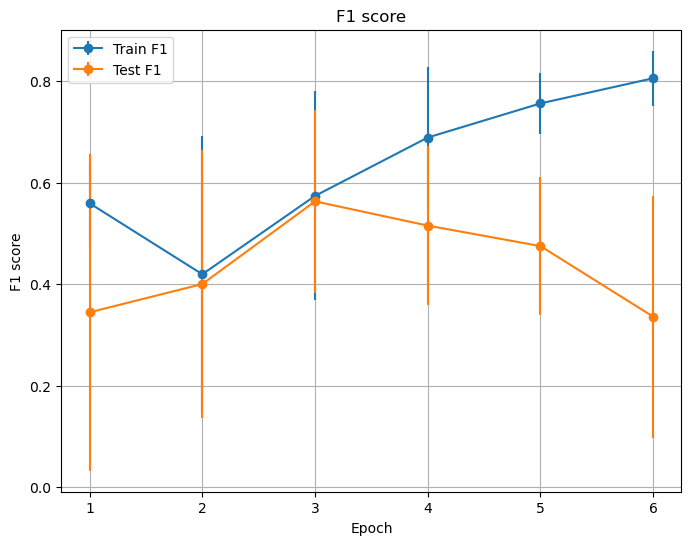

In [11]:
ihb_real_f1 = conduct_experiments(data, labels)

Training on baseline augmented data


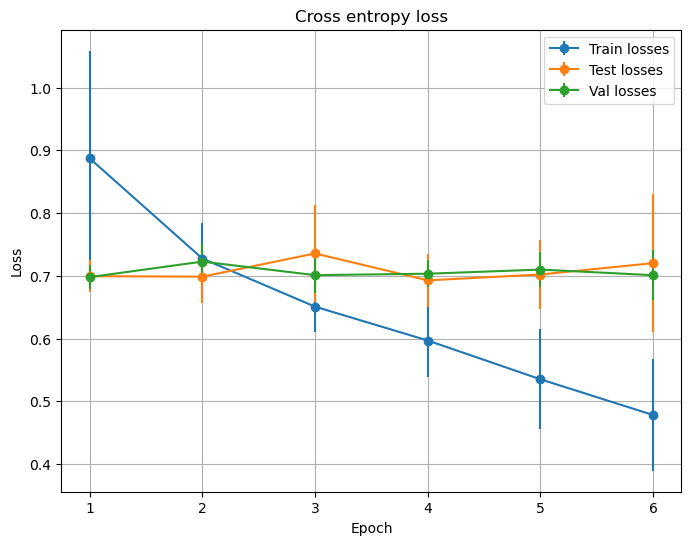

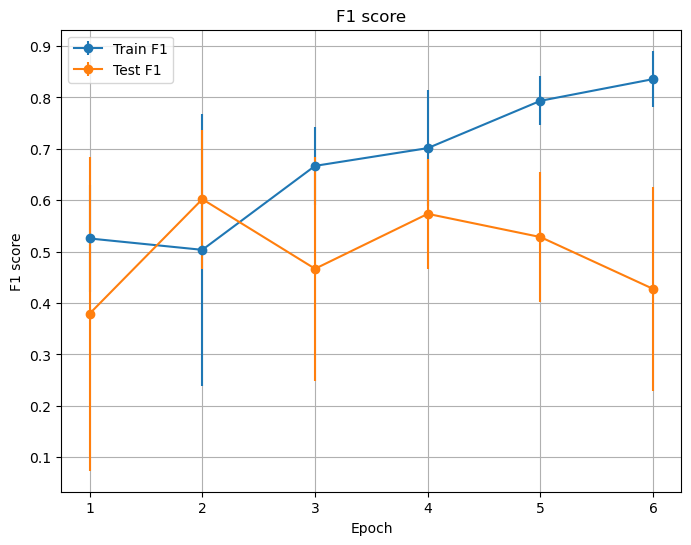

Training on combined data


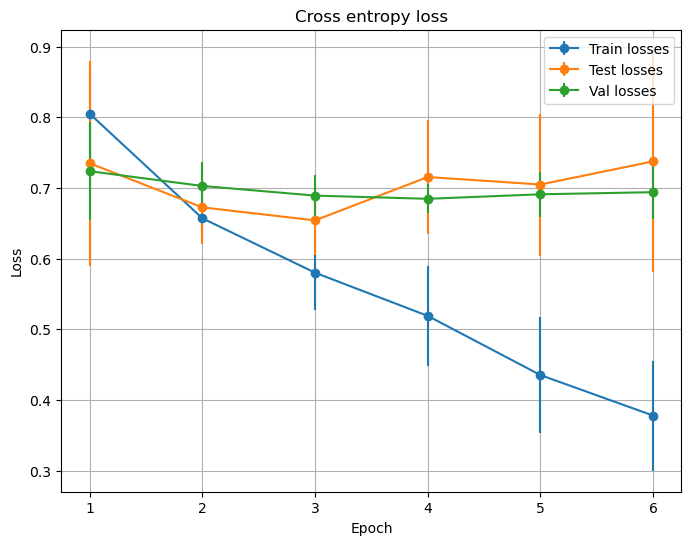

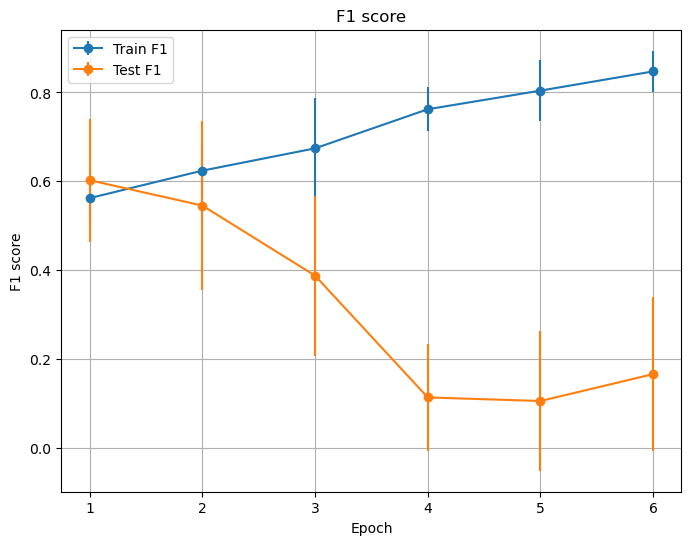

Training on diffusion augmented data


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/job-2013465/ipykernel_247416/3433225188.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(sample, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
100%|██████████| 10/10 [08:11<00:00, 49.19s/it]
/tmp/job-2013465/ipykernel_247416/3433225188.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(sample, dtype=torch.float32).unsqueeze(0).unsqueeze(0)


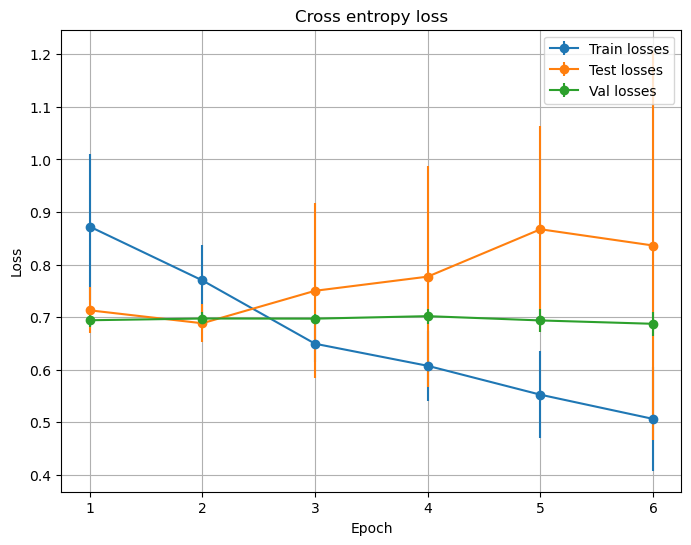

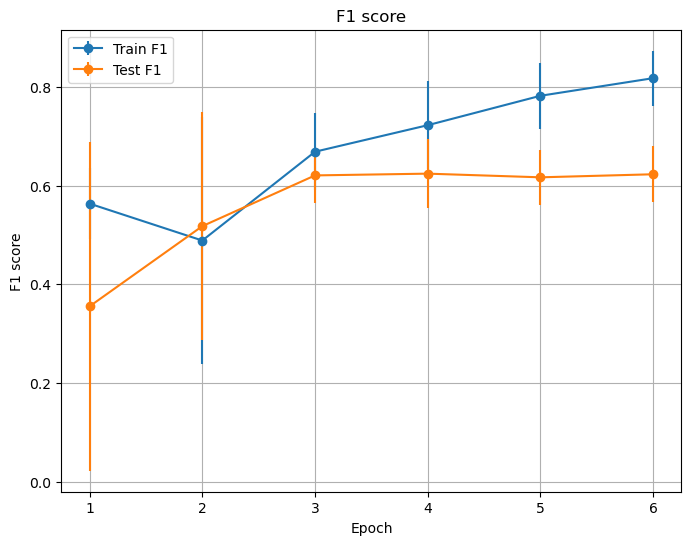

Training on combined data


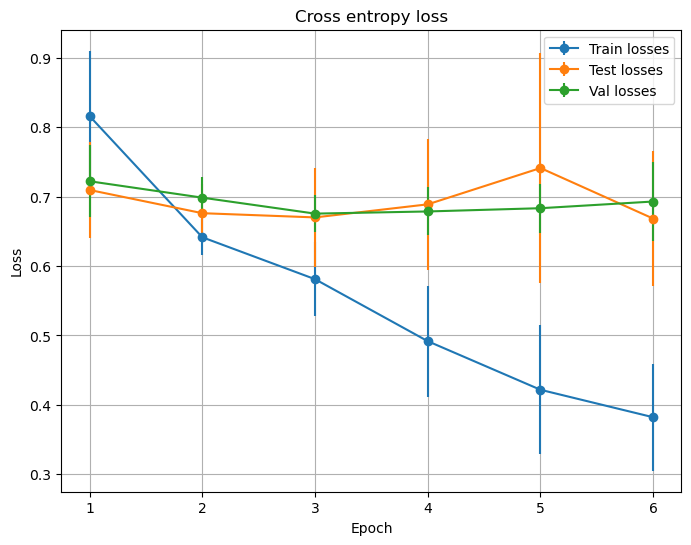

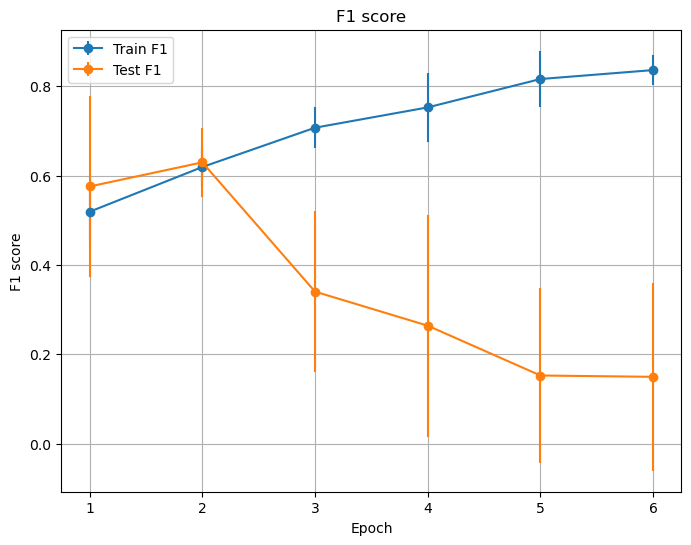

Training on transformer augmented data


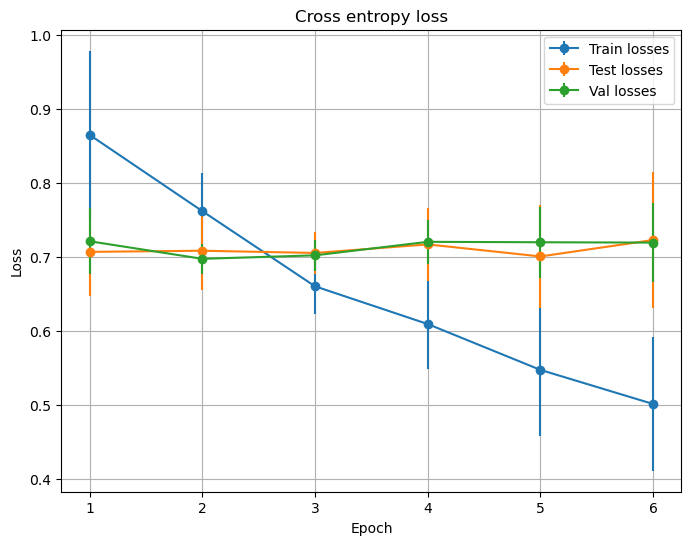

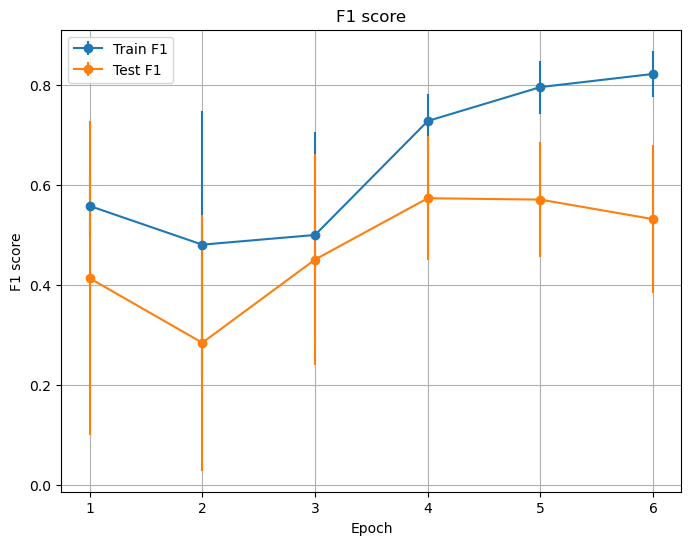

Training on combined data


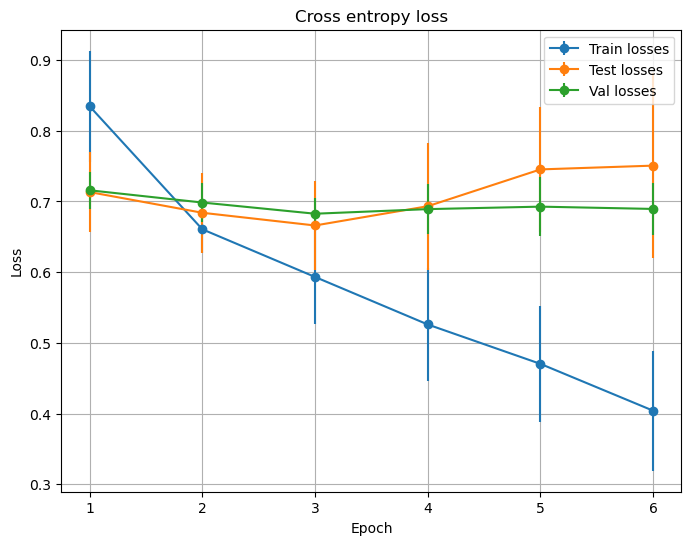

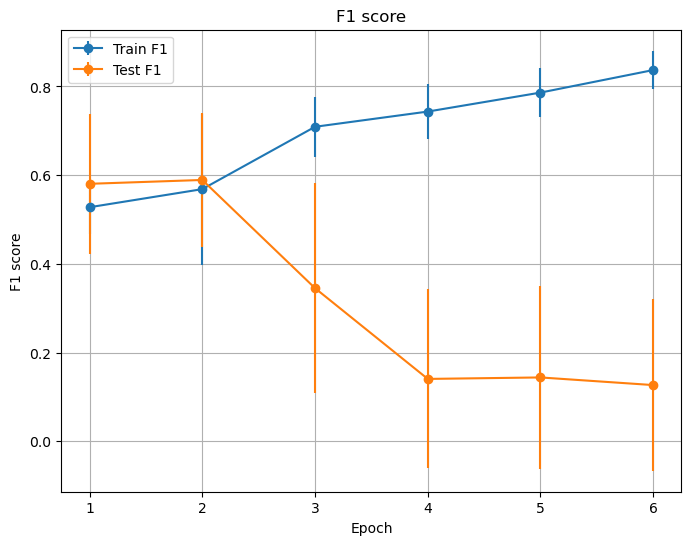

In [12]:
aug_types = ["baseline", "diffusion", "transformer"]
ihb_aug_f1 = []
ihb_comb_f1 = []
for aug_type in aug_types:
    print("Training on " + aug_type + " augmented data")
    augmented_data, aug_labels = get_aug_data(data, aug_type, dataset_name)
    ihb_aug_f1.append(conduct_experiments_aug(data, augmented_data, labels, aug_labels))
    print("Training on combined data")
    combined_data = torch.cat((data, augmented_data), axis=0)
    combined_labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) +\
    [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample)
    combined_labels = torch.tensor(combined_labels).float()
    ihb_comb_f1.append(conduct_experiments_aug(data, combined_data, labels, combined_labels))

## IHB results

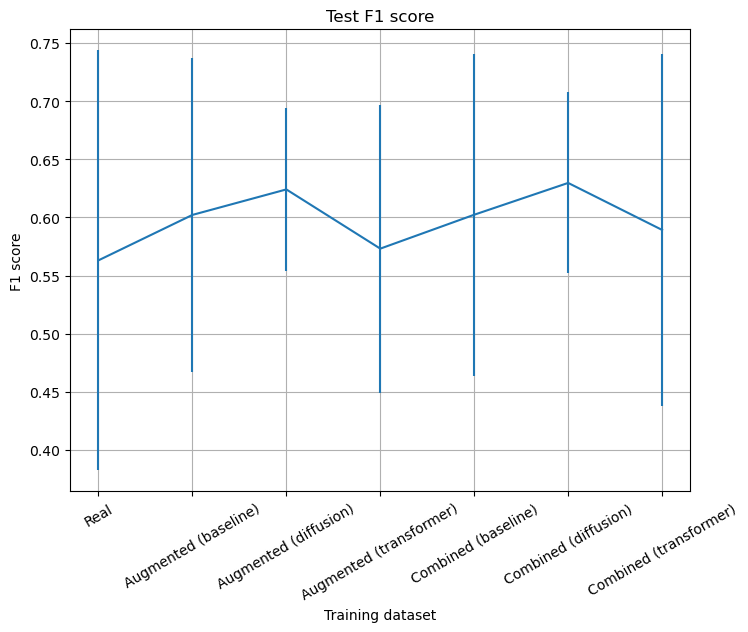

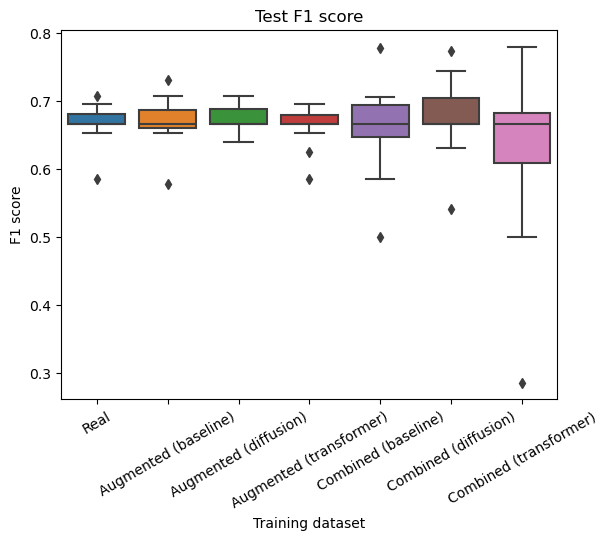

In [13]:
plot_results(ihb_real_f1, ihb_aug_f1, ihb_comb_f1)

## Beijing university dataset

In [14]:
dataset_name = "china_cut"
close, open, data = load_data(dataset_name)
labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

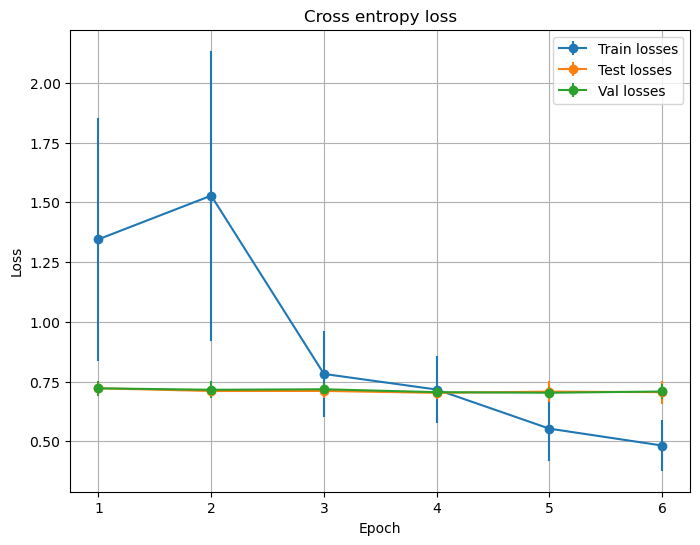

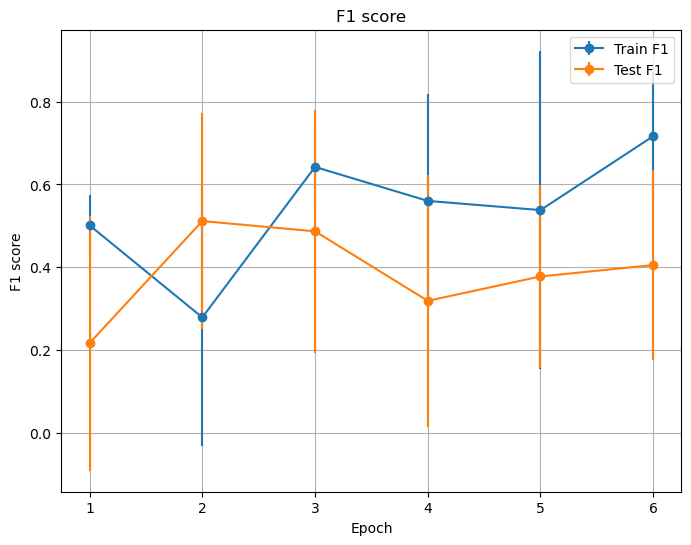

In [15]:
china_cut_real_f1 = conduct_experiments(data, labels, conv_output_size=2912)

Training baseline


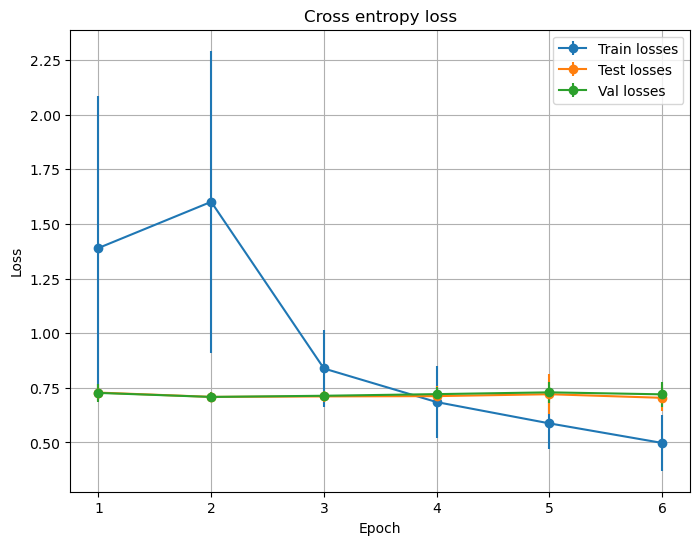

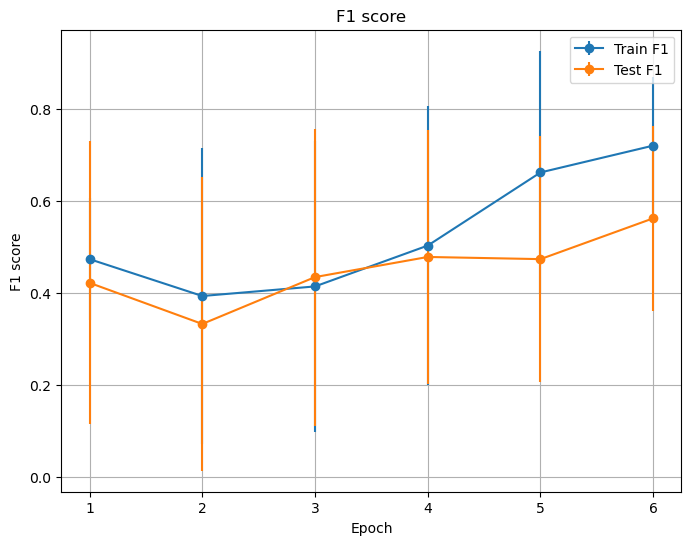

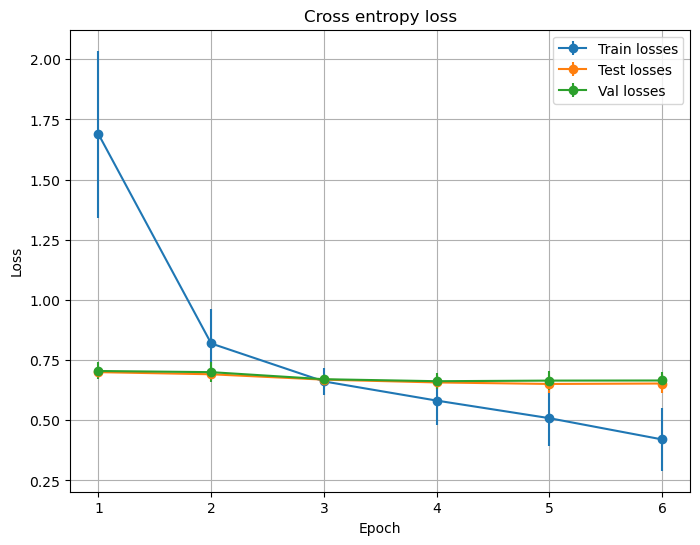

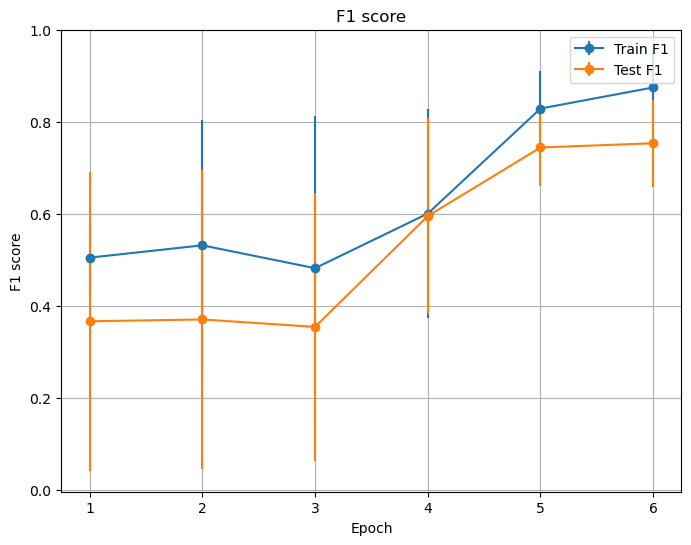

Training diffusion


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/job-2013465/ipykernel_247416/3433225188.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(sample, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
100%|██████████| 10/10 [09:01<00:00, 54.18s/it]
/tmp/job-2013465/ipykernel_247416/3433225188.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(sample, dtype=torch.float32).unsqueeze(0).unsqueeze(0)


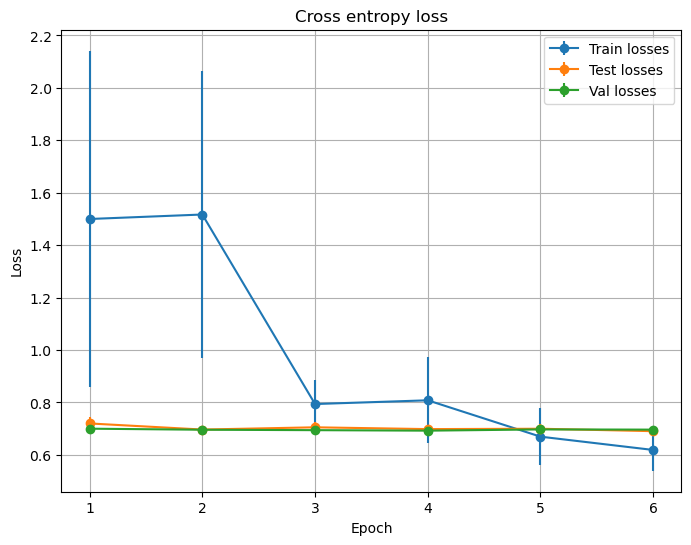

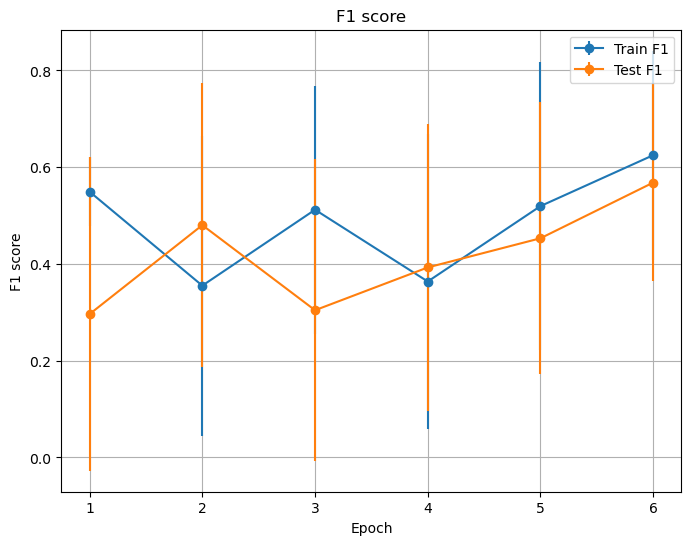

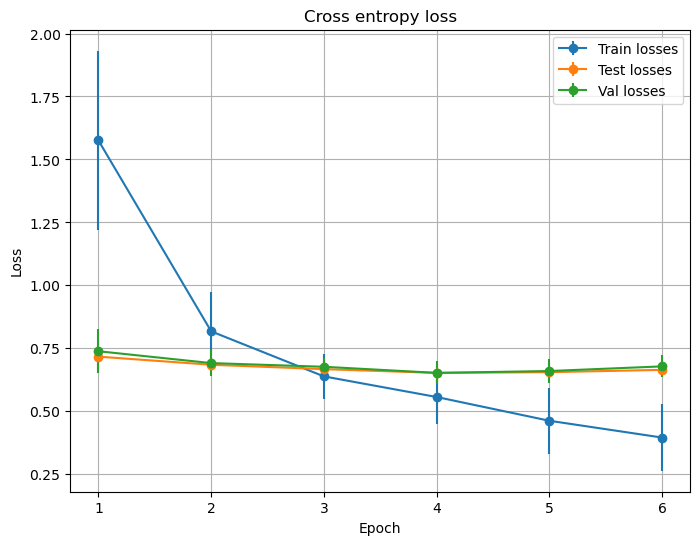

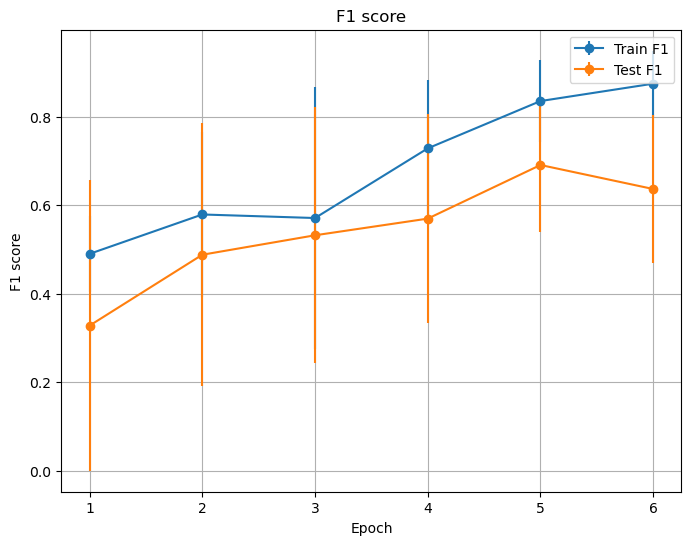

Training transformer


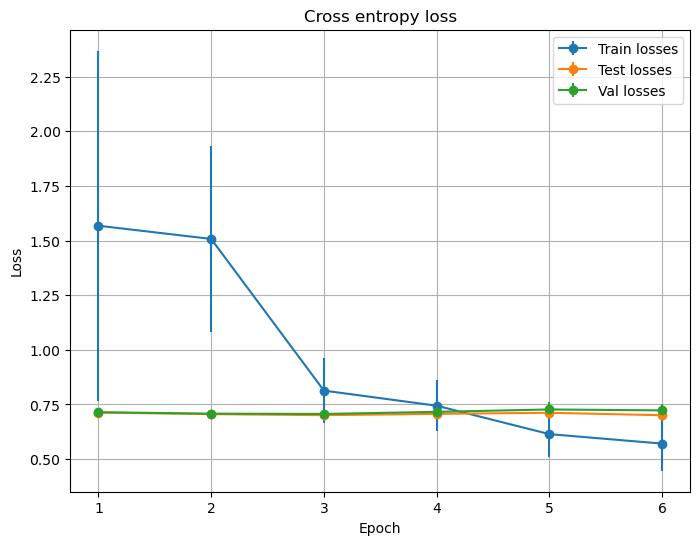

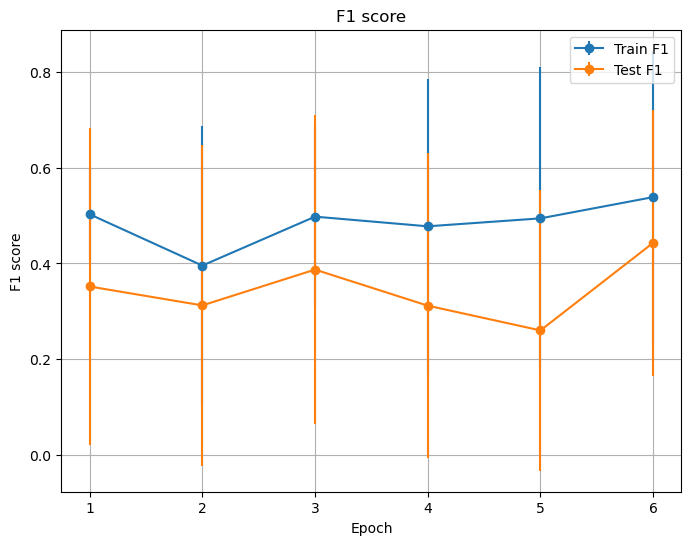

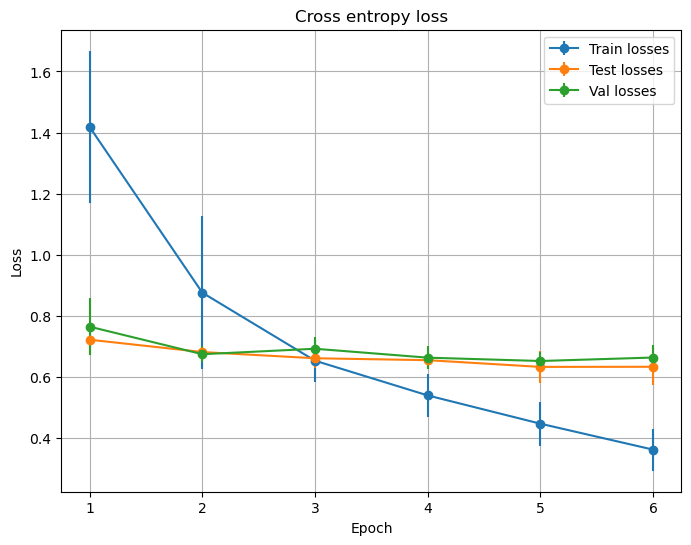

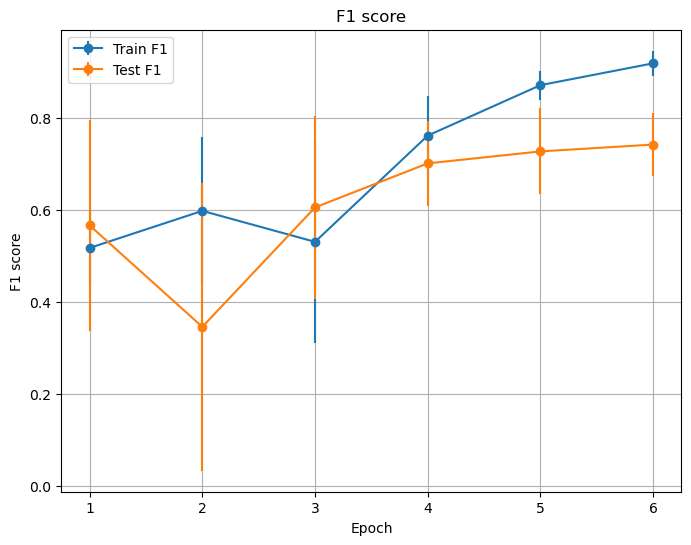

In [16]:
aug_types = ["baseline", "diffusion", "transformer"]
china_cut_aug_f1 = []
china_cut_comb_f1 = []
for aug_type in aug_types:
    print("Training " + aug_type)
    augmented_data, aug_labels = get_aug_data(data, aug_type, dataset_name)
    china_cut_aug_f1.append(conduct_experiments_aug(data, augmented_data, labels, aug_labels, conv_output_size=2912))
    combined_data = torch.cat((data, augmented_data), axis=0)
    combined_labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) +\
    [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample)
    combined_labels = torch.tensor(combined_labels).float()
    china_cut_comb_f1.append(conduct_experiments_aug(data, combined_data, labels, combined_labels, conv_output_size=2912))

## Beijing results

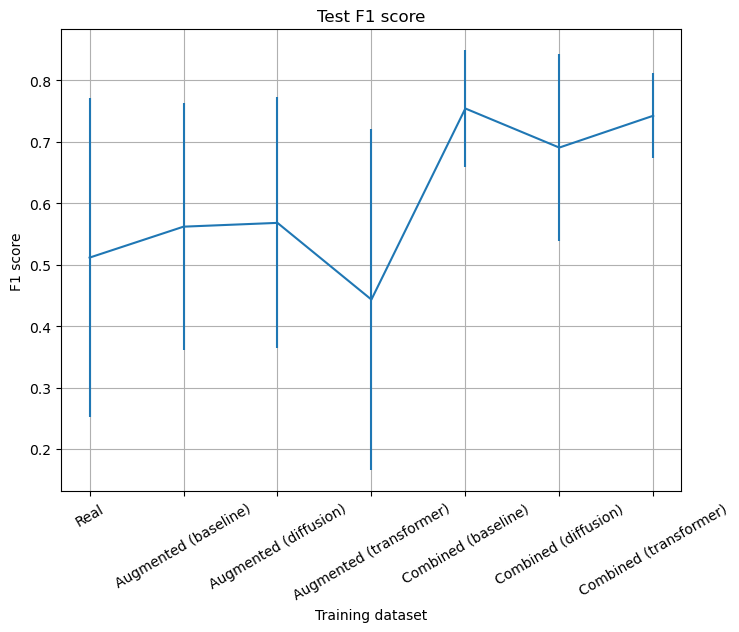

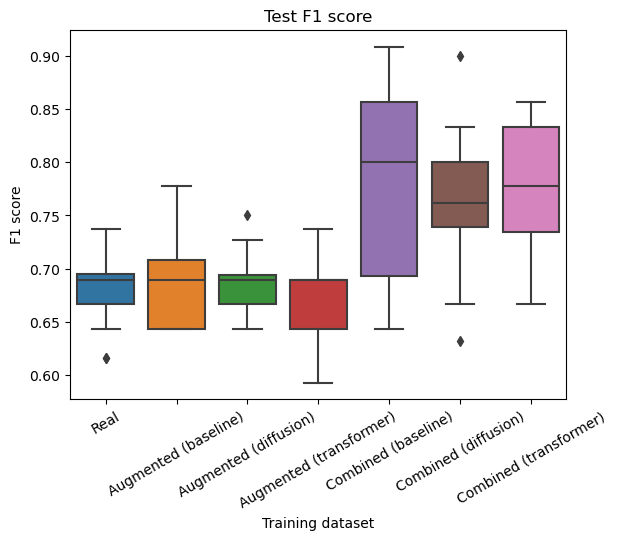

In [17]:
plot_results(china_cut_real_f1, china_cut_aug_f1, china_cut_comb_f1)